# Comparison between different algorithms for calculating the magnetic field produced by elipsoids

The magnetic induction field produced by elipsoids can be calculated by different algorithms, depending on the shape of the elipsoid. Emerson XXXX (XXXXXX) proposed algorithms for calculating the magnetic field produced by prolate and oblates elipsoids. Clark (XXXXXX) bla bla bla

This code compares the magnetic field produced by bla bla bla


* Reference 1
* Reference 2

### Required dependencies

In [32]:
import numpy as np
from scipy import linalg
from matplotlib import pyplot as plt

from fatiando.gravmag import sphere
from fatiando import mesher, gridder, utils
from fatiando.vis import mpl

%matplotlib inline

### Auxiliary functions

In [33]:
import Elipsoide_Clark_FAT as me
import Modelagem_Elipsoide_Emerson_Prolato as me2

### Computation points

In [34]:
# Malha coordenadas geograficas
xmin = -100.
xmax = 100.
ymin = -90.
ymax = 90.
Nx = 200
Ny = 200

In [35]:
# Create a regular grid at 0m height
shape = (Nx, Ny)
area = [xmin, xmax, ymin, ymax]
Xp, Yp, Zp = gridder.regular(area, shape, z=0.)

### Geomagnetic field

In [36]:
# Set the inclination and declination of the regional field
inten, inc, dec  = 60000., np.deg2rad(90.), np.deg2rad(0.)

### Center of the ellipsoid

In [37]:
#xc posicao x , yc posição y e zc profundidade reais
xc = 0.
yc = 0.
zc = 100.

### Remanent magnetization and susceptibility tensor

In [38]:
#vetor magnetização remanente
intensidade = 10000.
inclinacao = np.deg2rad(90.)
declinacao = np.deg2rad(0.)

#vetor de susceptibilidades
intensidadeA = 0.10
inclinacaoA = np.deg2rad(90.)
declinacaoA = np.deg2rad(0.)
intensidadeB = 0.10
inclinacaoB = np.deg2rad(180.)
declinacaoB = np.deg2rad(0.)
intensidadeC = 0.10
inclinacaoC = np.deg2rad(0.)
declinacaoC = np.deg2rad(90.)
k_int = np.array([[intensidadeA],
                  [intensidadeB],
                  [intensidadeC]])
k_inc = np.array([[inclinacaoA],
                  [inclinacaoB],
                  [inclinacaoC]])
k_dec = np.array([[declinacaoA],
                  [declinacaoB],
                  [declinacaoC]])

### Ellipsoid orientation 

In [39]:
# Orientacoes do elipsoide
azimute = 0.
alfa = np.deg2rad(azimute+180.)
delta = np.deg2rad(0.)
gamma = np.deg2rad(0.)

### Reference axis and axis difference

In [40]:
daxis = 0.01
aref = 5.

# Fatiando a Terra - Ellipsoid Clark

In [41]:
# Ellipsoid axis
a = aref + daxis
b = aref
c = aref - daxis

################################################################################################################################

# Create a ellipsoid model
model = [me.Ellipsoid(xc, yc, zc, a, b, c, alfa, delta, gamma, {'remanence': np.array([10000, np.deg2rad(90.), np.deg2rad(0.)]),
                                                            'k1': np.array([(0.1), np.deg2rad(90.), np.deg2rad(0.)]),
                                                            'k2': np.array([(0.1), np.deg2rad(180.), np.deg2rad(0.)]),
                                                            'k3': np.array([(0.1), np.deg2rad(0.), np.deg2rad(90.)])})]

# Calculate the anomaly for a given regional field
Bx = me.bx_c (Xp,Yp,Zp,inten,inc,dec,model)
By = me.by_c (Xp,Yp,Zp,inten,inc,dec,model)
Bz = me.bz_c (Xp,Yp,Zp,inten,inc,dec,model)
Tf,jrd_ang = me.tf_c (Xp,Yp,Zp,inten,inc,dec,model)
print jrd_ang

[13802.636087458401, 90.0, 3.9350732698437098e-16]


# Implementation  - Ellipsoid Emerson Prolate

In [42]:
# Ellipsoid axis
a = aref + daxis
b = aref - daxis

#Construção matriz de susceptibilidades k
l1 = me2.l1_v (alfa, delta)
l2 = me2.l2_v (alfa, delta)
l3 = me2.l3_v (alfa, delta)    
m1 = me2.m1_v (alfa, delta)
m2 = me2.m2_v (alfa, delta)
m3 = me2.m3_v (alfa, delta)    
n1 = me2.n1_v (delta)
n2 = me2.n2_v (delta)
n3 = me2.n3_v (delta)
Lr = me2.Lr_v (k_dec, k_inc)
Mr = me2.Mr_v (k_dec, k_inc)
Nr = me2.Nr_v (k_inc)

if k_int[0] == k_int[1] and k_int[0] == k_int[2]:
    km = me2.k_matrix2 (k_int,l1,l2,l3,m1,m2,m3,n1,n2,n3)
else:
    Lr = me2.Lr_v (k_dec, k_inc)
    Mr = me2.Mr_v (k_dec, k_inc)
    Nr = me2.Nr_v (k_inc)
    km = me2.k_matrix (k_int,Lr,Mr,Nr,l1,l2,l3,m1,m2,m3,n1,n2,n3)

Bx_P, By_P, Bz_P = me2.elipsoide (a,b,zc,alfa,delta,Xp,Yp,Zp,xc,yc,declinacao,inclinacao,intensidade,dec,inc,inten,km)

Tf_P = (Bx_P*np.cos(inc)*np.cos(dec) + By_P*np.cos(inc)*np.sin(dec) + Bz_P*np.sin(inc))

[11271.186665950174, array([ 90.]), array([ -9.93263939e-18])]


## Resultado da minha função

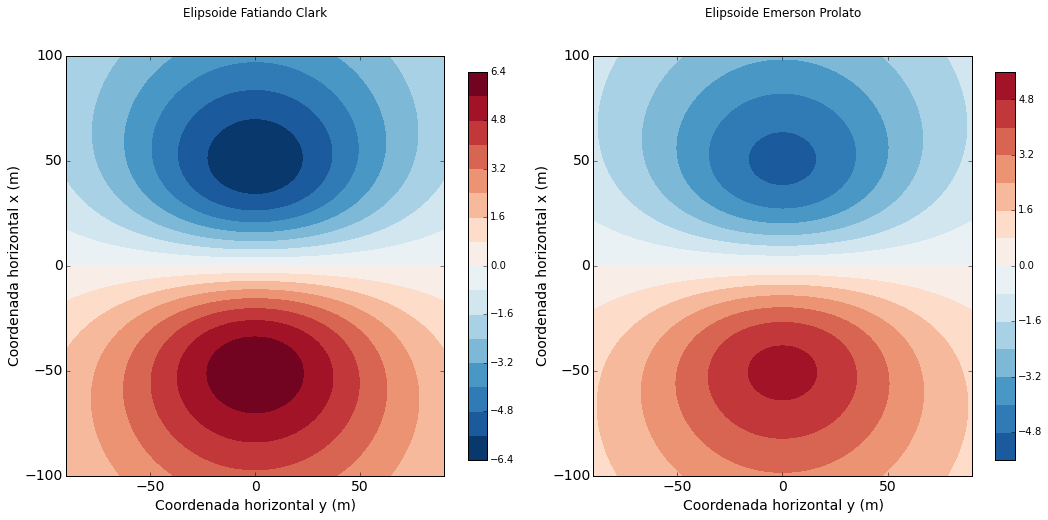

In [43]:
rangesBx = np.max(np.abs([np.max(Bx), np.min(Bx),
                          np.max(Bx_P), np.min(Bx_P)]))

plt.figure(figsize=(15,8))

plt.subplot(1,2,1)
plt.title('Elipsoide Fatiando Clark', y=1.08)
plt.axis('scaled')
plt.tricontourf(Yp,Xp,Bx,15,
            vmin = -rangesBx, vmax = rangesBx,
            cmap=plt.cm.RdBu_r)
cb = plt.colorbar(shrink=0.7)
plt.xlim(ymin,ymax)
plt.ylim(xmin,xmax)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Coordenada horizontal y (m)', fontsize=14)
plt.ylabel('Coordenada horizontal x (m)', fontsize=14)

plt.subplot(1,2,2)
plt.title('Elipsoide Emerson Prolato', y=1.08)
plt.axis('scaled')
plt.tricontourf(Yp,Xp,Bx_P,15,
            vmin = -rangesBx, vmax = rangesBx,
            cmap=plt.cm.RdBu_r)
cb = plt.colorbar(shrink=0.7)
plt.xlim(ymin,ymax)
plt.ylim(xmin,xmax)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Coordenada horizontal y (m)', fontsize=14)
plt.ylabel('Coordenada horizontal x (m)', fontsize=14)

plt.tight_layout()

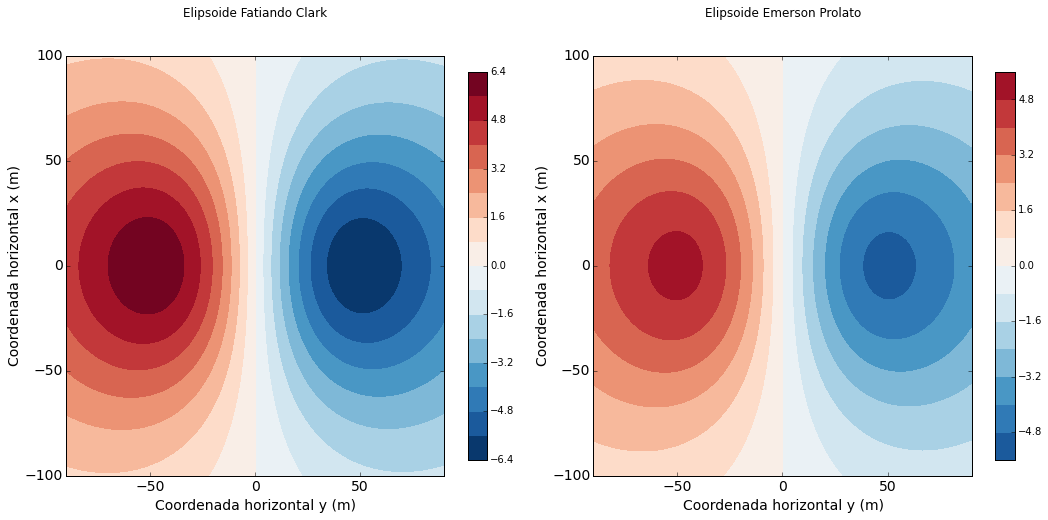

In [44]:
rangesBy = np.max(np.abs([np.max(By), np.min(By),
                          np.max(By_P), np.min(By_P)]))

plt.figure(figsize=(15,8))

plt.subplot(1,2,1)
plt.title('Elipsoide Fatiando Clark', y=1.08)
plt.axis('scaled')
plt.tricontourf(Yp,Xp,By,15,
            vmin = -rangesBy, vmax = rangesBy,
            cmap=plt.cm.RdBu_r)
cb = plt.colorbar(shrink=0.7)
plt.xlim(ymin,ymax)
plt.ylim(xmin,xmax)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Coordenada horizontal y (m)', fontsize=14)
plt.ylabel('Coordenada horizontal x (m)', fontsize=14)

plt.subplot(1,2,2)
plt.title('Elipsoide Emerson Prolato', y=1.08)
plt.axis('scaled')
plt.tricontourf(Yp,Xp,By_P,15,
            vmin = -rangesBy, vmax = rangesBy,
            cmap=plt.cm.RdBu_r)
cb = plt.colorbar(shrink=0.7)
plt.xlim(ymin,ymax)
plt.ylim(xmin,xmax)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Coordenada horizontal y (m)', fontsize=14)
plt.ylabel('Coordenada horizontal x (m)', fontsize=14)

plt.tight_layout()

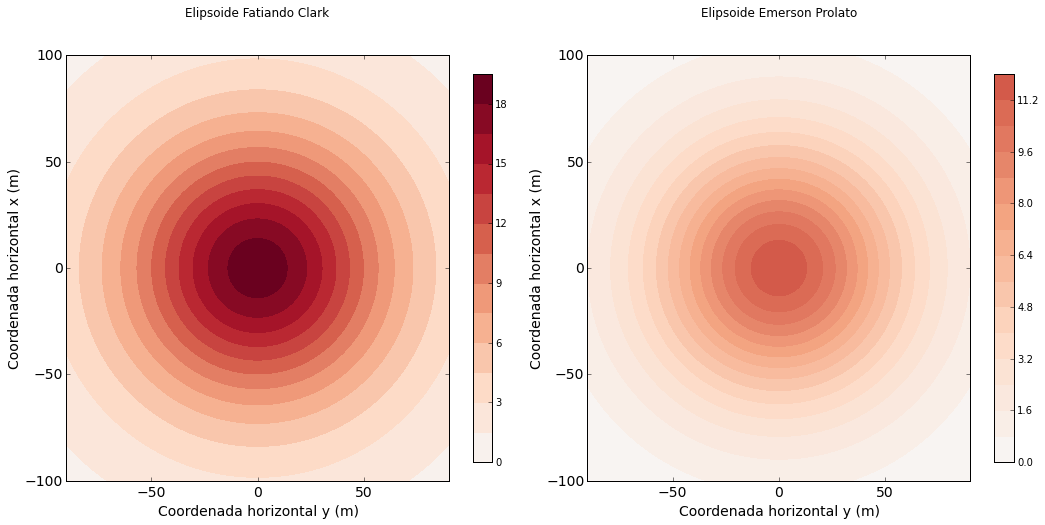

In [45]:
rangesBz = np.max(np.abs([np.max(Bz), np.min(Bz),
                          np.max(Bz_P), np.min(Bz_P)]))

plt.figure(figsize=(15,8))

plt.subplot(1,2,1)
plt.title('Elipsoide Fatiando Clark', y=1.08)
plt.axis('scaled')
plt.tricontourf(Yp,Xp,Bz,15,
            vmin = -rangesBz, vmax = rangesBz,
            cmap=plt.cm.RdBu_r)
cb = plt.colorbar(shrink=0.7)
plt.xlim(ymin,ymax)
plt.ylim(xmin,xmax)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Coordenada horizontal y (m)', fontsize=14)
plt.ylabel('Coordenada horizontal x (m)', fontsize=14)

plt.subplot(1,2,2)
plt.title('Elipsoide Emerson Prolato', y=1.08)
plt.axis('scaled')
plt.tricontourf(Yp,Xp,Bz_P,15,
            vmin = -rangesBz, vmax = rangesBz,
            cmap=plt.cm.RdBu_r)
cb = plt.colorbar(shrink=0.7)
plt.xlim(ymin,ymax)
plt.ylim(xmin,xmax)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Coordenada horizontal y (m)', fontsize=14)
plt.ylabel('Coordenada horizontal x (m)', fontsize=14)

plt.tight_layout()

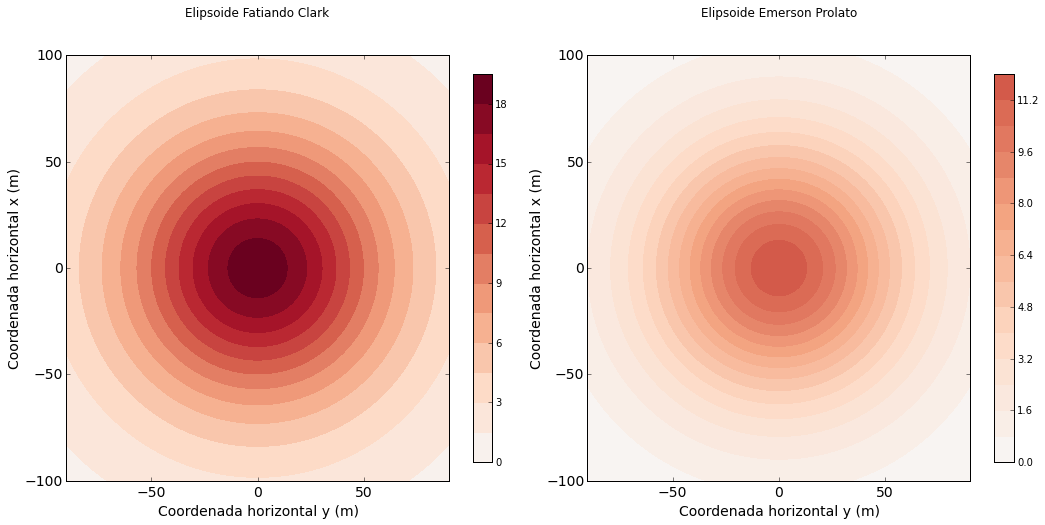

In [46]:
rangesTf = np.max(np.abs([np.max(Tf), np.min(Tf),
                          np.max(Tf_P), np.min(Tf_P)]))

plt.figure(figsize=(15,8))

plt.subplot(1,2,1)
plt.title('Elipsoide Fatiando Clark', y=1.08)
plt.axis('scaled')
plt.tricontourf(Yp,Xp,Tf,15,
            vmin = -rangesTf, vmax = rangesTf,
            cmap=plt.cm.RdBu_r)
cb = plt.colorbar(shrink=0.7)
plt.xlim(ymin,ymax)
plt.ylim(xmin,xmax)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Coordenada horizontal y (m)', fontsize=14)
plt.ylabel('Coordenada horizontal x (m)', fontsize=14)

plt.subplot(1,2,2)
plt.title('Elipsoide Emerson Prolato', y=1.08)
plt.axis('scaled')
plt.tricontourf(Yp,Xp,Tf_P,15,
            vmin = -rangesTf, vmax = rangesTf,
            cmap=plt.cm.RdBu_r)
cb = plt.colorbar(shrink=0.7)
plt.xlim(ymin,ymax)
plt.ylim(xmin,xmax)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Coordenada horizontal y (m)', fontsize=14)
plt.ylabel('Coordenada horizontal x (m)', fontsize=14)

plt.tight_layout()